# Supervised Shallow Machine Learning: Multiple Linear Regression

<div class="alert alert-info" role="alert" 
     style="font-size: 1.2em; padding: 10px; margin: 10px 0; text-align: center;">
    
    Multiple Linear Regression models the relationship between one continuous dependent variable and two or more independent variables using a linear equation fitted by Ordinary Least Squares (OLS).
</div>

### Import Libraries including from `sklearn` for shallow ML

In [1]:
# Data Wrangling
import glob
import pandas as pd
import numpy as np

# Machine Learn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Data Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Data Preprocessing
</div>

### Option 1 to Load CSV files containing variables -- pandas' `read_csv function`

In [2]:
# Data are imported in Dataframe format
SSH = pd.read_csv("cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_SSH.csv", comment='#') # tells pandas to ignore lines starting with '#'
SST = pd.read_csv("cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_SST.csv", comment='#')
SSS = pd.read_csv("cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_SSs.csv", comment='#')
VEL = pd.read_csv("cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_VEL.csv", comment='#')
MLD = pd.read_csv("cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_MLD.csv", comment='#')

In [3]:
# The UTC format that our dates (times) are currently in:
SSH['dates'] = pd.to_datetime(SSH['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)

# Step1: convert to a more friendly format, add 'dates' as new column 
SSH['dates'] = SSH['dates'].dt.strftime('%Y-%m-%d %H:%M')
# Step2: Remove the times in this case as they contain no real information
SSH['dates'] = pd.to_datetime(SSH['dates'])
# Step3: Drop the now unnecessary 'time' column
SSH = SSH.drop(columns=['time'])

# Re-order your columns so date is still first
SSH = SSH[['dates','zos']]
# Display
print(SSH.tail(2))

           dates       zos
10406 2021-06-29 -0.166631
10407 2021-06-30 -0.170293


In [4]:
# We can now combine these different vars to make a new df
df = pd.DataFrame({'Date':SSH['dates'], 'SSH':SSH['zos'], 'SST':SST['thetao'], 'SSS':SSS['so'], 
                   'Vuo':VEL['uo'], 'Vvo':VEL['vo'], 'MLD':MLD['mlotst']})
print(df.head(5))

        Date       SSH        SST        SSS       Vuo       Vvo        MLD
0 1993-01-01 -0.096133  25.840723  36.259041 -0.104373  0.850246  66.225166
1 1993-01-02 -0.106815  25.672995  36.251411 -0.169683  0.775780  69.124428
2 1993-01-03 -0.137028  25.314096  36.233101 -0.120243  0.763573  63.325909
3 1993-01-04 -0.170598  25.159552  36.242256  0.032960  0.979034  50.813320
4 1993-01-05 -0.165105  25.166143  36.240730  0.083010  1.031526  49.897766


### Option 2 to Load CSV files containing variables -- `glob` and pandas' `read_csv function`

### Set the `predictor` and `target` variables (X, y)

In [5]:
predictors = ['SSH', 'SSS', 'Vuo', 'Vvo', 'MLD'] # Predictor vars
X = df[predictors].values 
y = df['SST'].values      # Target variable
# Needs to be (n,n)(n,)
print(X.shape, y.shape)

(10408, 5) (10408,)


### Split the data into two sets: `training` (80%) and `test` (20%)

In [6]:
# Split your dataset so 20% is set aside for testing (0.2) 
# Set random_state to ensure yr train-test split is always the same (for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the 80% training: 20% testing split
print("Trainin set size:", X_train.shape[0])
print("Testing set size:",  X_test.shape[0])

Trainin set size: 8326
Testing set size: 2082


<div class="alert alert-info" role="alert" 
     style="font-size: 1.4em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    Ordinary Least Squares (OLS) Approach for Multiple Variables (MV): 
    Linear Regression
</div>

In [7]:
# Fit LinearRegression (lin_reg) model on training data
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

# Predict SST for train and test sets
y_train_pred= lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test )

### Metrics for Multivariate Regression: `R2` and `RMSE`

In [8]:
# R², MSE, RMSE for LinRegres Model
r2  = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred, squared=False)
rmse= np.sqrt(mse)

# Print output
print(f"Multi Linear Regression R²  : {r2:.2f}" )
print(f"Multi Linear Regression MSE : {mse:.2f}")
print(f"Multi Linear Regression RMSE: {rmse:.2f}")

Multi Linear Regression R²  : 0.62
Multi Linear Regression MSE : 1.23
Multi Linear Regression RMSE: 1.11


<div class="alert alert-info" role="alert" 
     style="font-size: 1.4em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    Elastic Net Regularisation
</div>

In [9]:
# Fit Elastic Net with cross-validation
elastic_net = ElasticNetCV(l1_ratio = [0.1, 0.5, 0.9],         # Mix of Lasso (L1) & Ridge (L2)
                           alphas = np.logspace(-3, 1, 100),   # Range of regularization strengths
                           cv = 5, random_state = 42)

In [10]:
#Fit the model on the training set
elastic_net.fit(X_train, y_train)

# Predict SST on the test dataset
y_en_pred = elastic_net.predict(X_test)

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Evaluating Model Performance
</div>

### Metrics for Multivariate Regression Model: `R2` and `RMSE`

In [11]:
# R², MSE, RMSE for Elastic Net Model
en_r2  = r2_score(y_test, y_en_pred)
en_mse = mean_squared_error(y_test, y_en_pred, squared = False)
en_rmse= np.sqrt(mse)

# Print output
print(f"Elastic Net Regression R²   : {en_r2:.2f}" )
print(f"Elastic Net Regression MSE  : {en_mse:.2f}")
print(f"Elastic Net Regression RMSE : {en_rmse:.2f}")

Elastic Net Regression R²   : 0.62
Elastic Net Regression MSE  : 1.23
Elastic Net Regression RMSE : 1.11


<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Feature Importance
</div>

In [12]:
# Feature Importance:
feature_importance_LR = pd.Series(lin_reg.coef_, index = predictors)
feature_importance_EN = pd.Series(elastic_net.coef_, index = predictors)

# Sort: important variables at the top (in descending order)
FI_LR = feature_importance_LR.sort_values(ascending = False)
FI_EN = feature_importance_EN.sort_values(ascending = False)

# Quick comparison:
print(FI_LR)
print()     #empty
print(FI_EN)

SSH    13.928749
Vuo     0.859539
Vvo     0.246630
MLD    -0.049385
SSS    -2.308833
dtype: float64

SSH    13.553087
Vuo     0.756465
Vvo     0.240072
MLD    -0.049295
SSS    -2.310009
dtype: float64


### Visualising Feature Importance: `bar plot`

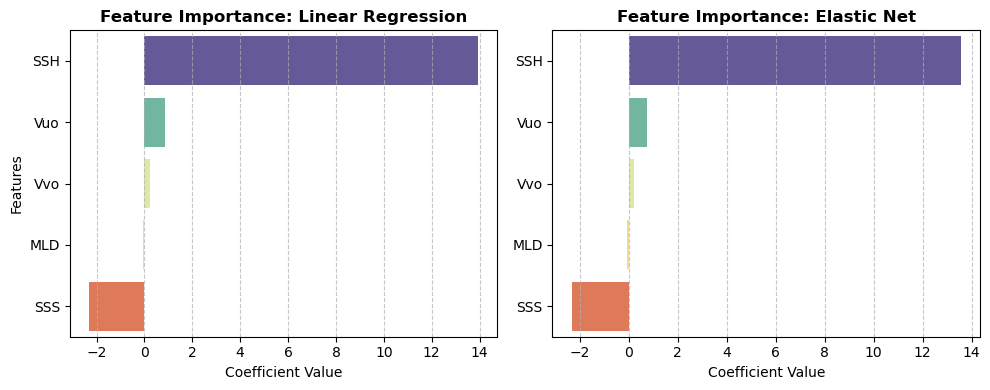

In [13]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

# Use diverging palette from Seaborn as before
cmap = sns.color_palette("Spectral", as_cmap = True)

# Create a list of colors for each feature based on the ranking (scaled between 0 and 1)
colors_lr = [cmap(x) for x in FI_LR.rank(pct = True)]
colors_en = [cmap(x) for x in FI_EN.rank(pct = True)]

# Create barplot for MV Linear Regression (OLS)
sns.barplot(x = FI_LR.values, y = FI_LR.index, palette = colors_lr, ax = ax1)
ax1.set_title("Feature Importance: Linear Regression", fontweight = 'bold')
ax1.set_xlabel("Coefficient Value", fontsize = 10)
ax1.set_ylabel("Features", fontsize = 10)
ax1.grid(axis = 'x', linestyle = '--', alpha = 0.7)

# Create barplot for Elastic Net (EN)
sns.barplot(x = FI_EN.values, y = FI_EN.index, palette = colors_en, ax = ax2)
ax2.set_title("Feature Importance: Elastic Net", fontweight = 'bold')
ax2.set_xlabel("Coefficient Value", fontsize = 10)
ax2.grid(axis = 'x', linestyle = '--', alpha = 0.7)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.em; padding: 15px; margin: 10px 0; text-align: left; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">

    ⦾ SSH appears to be the dominant predictor for both models, with the other variables contributing little to nothing.
    
    ⦾ BUT these models only capture linear relationships.
    
    ⦾ Additionally, ElasticNet shrinks coefficients that don't add much linearly (L1 and L2 penalties). 
       - Good: regularisation reduces overfitting.
       - Less good: other predictors can appear unimportant — even if they contribute, and especially when they're correlated.
        
    ⦾ Correlated predictors tend to share predictive power, so the penalty may disproportionately reduce their individual 
      coefficients, making it seem like they have little value in the ranking.
      .
    
</div>

### Ultimately, we've likely reached the limit of what linear models can do for us. If we're dealing with `non-linearity`... we need to upgrade to a model that can account for this!

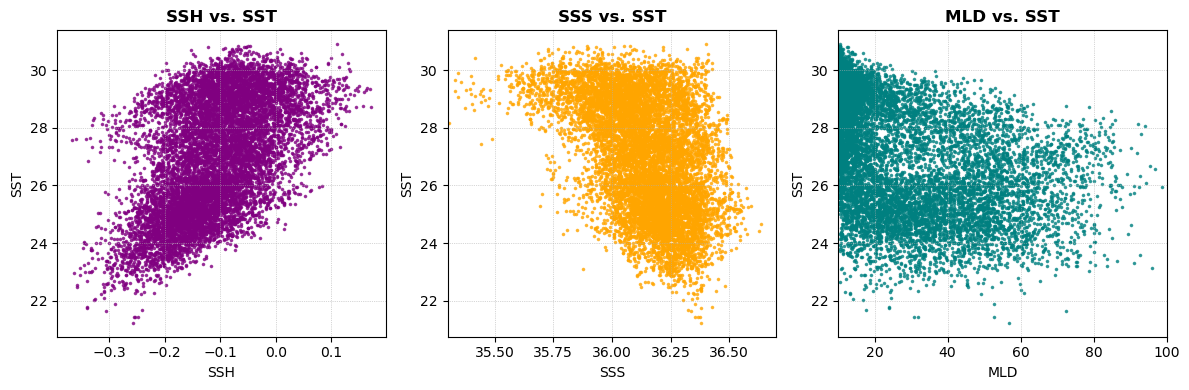

In [14]:
# Create a figure with 1 row and 2 columns of subplots
fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# ---------------------------
# Scatterplot: SSH vs. SST
ax1.scatter(df['SSH'], df['SST'], color='purple', alpha=0.7, marker='.', s=10)
ax1.set_xlabel('SSH')                           # Label for the x-axis
ax1.set_ylabel('SST')                           # Label for the y-axis
ax1.set_title('SSH vs. SST' , weight='bold')    # Title for this subplot
ax1.grid(True, linestyle=':', linewidth=0.5)    # Add a dotted grid for clarity

# ---------------------------
# Scatterplot: SSS vs. SST
ax2.scatter(df['SSS'], df['SST'], color='orange', alpha=0.7, marker='.', s=10)
ax2.set_xlabel('SSS')                           # Label for the x-axis
ax2.set_ylabel('SST')                           # Label for the y-axis
ax2.set_xlim([35.3, 36.7])
ax2.set_title('SSS vs. SST' , weight='bold')    # Title for this subplot
ax2.grid(True, linestyle=':', linewidth=0.5)    # Add a dotted grid for clarity

# ---------------------------
# Scatterplot: MLD vs. SST
ax3.scatter(df['MLD'], df['SST'], color='teal', alpha=0.7, marker='.', s=10)
ax3.set_xlabel('MLD')                           # Label for the x-axis
ax3.set_ylabel('SST')                           # Label for the y-axis
ax3.set_xlim([10, 100])
ax3.set_title('MLD vs. SST' , weight='bold')    # Title for this subplot
ax3.grid(True, linestyle=':', linewidth=0.5)    # Add a dotted grid for clarity

# Adjust layout to prevent overlapping elements
plt.tight_layout()
# Display
plt.show()